In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

keras = tf.keras

In [ ]:
df=pd.read_csv("NVDA.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,0.984375,0.992188,0.919271,0.975260,0.894608,30091200
1,2000-01-04,0.958333,0.960938,0.901042,0.949219,0.870721,30048000
2,2000-01-05,0.921875,0.937500,0.904948,0.917969,0.842055,18835200
3,2000-01-06,0.917969,0.917969,0.822917,0.858073,0.787112,12048000
4,2000-01-07,0.854167,0.881510,0.841146,0.872396,0.800251,7118400


In [ ]:
closing_price=df["Close"]
dates=df["Date"]
df['Date'] = pd.to_datetime(df['Date'])
df['DateSerial'] = df['Date'].apply(lambda x: x.toordinal())
dates=df["DateSerial"]-df["DateSerial"][0]

In [ ]:
series = df['Close']

# Create train data set
train_split_date = '2020-12-31'
train_split_index = np.where(df.Date == train_split_date)[0][0]
x_train = df.loc[df['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2023-02-02'
test_split_index = np.where(df.Date == test_split_date)[0][0]
x_test = df.loc[df['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = df.loc[(df['Date'] < test_split_date) & (df['Date'] > train_split_date)]['Close']

5283 5284 5807 5808 6115


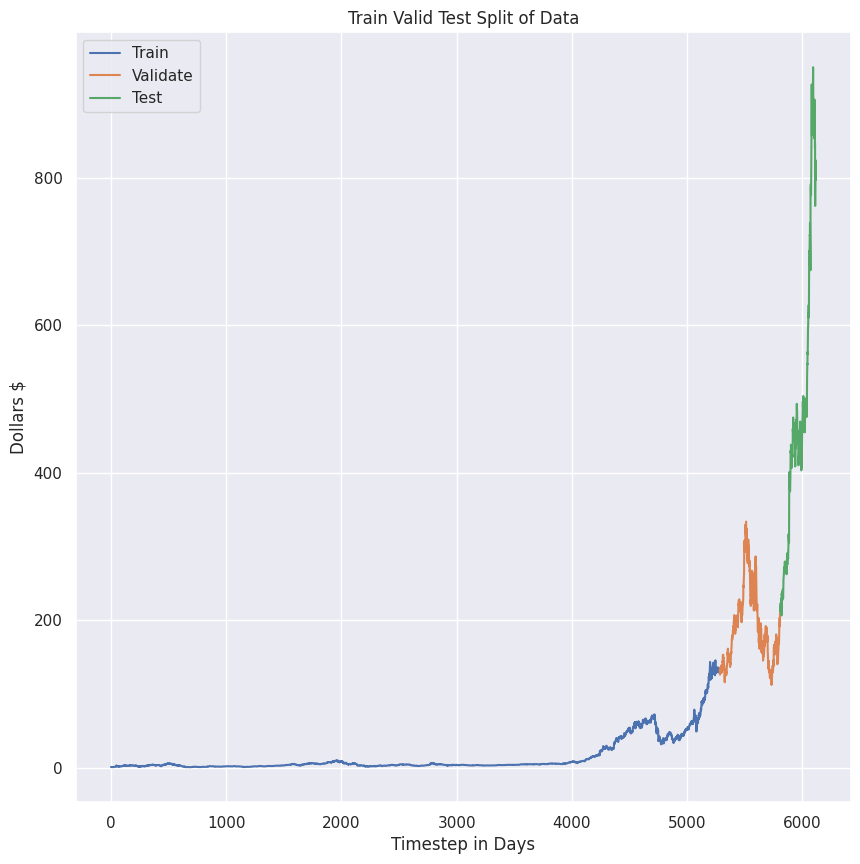

In [ ]:
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [ ]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}

Text(0.5, 1.0, 'Price History of TSLA Jan-1993 to Dec-2020')

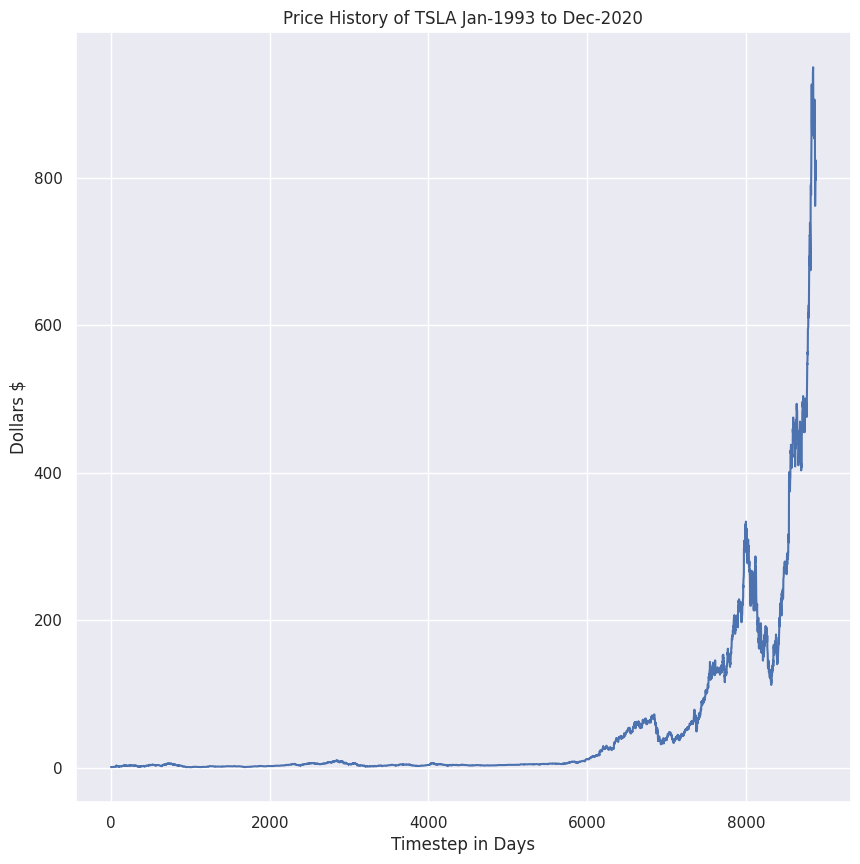

In [ ]:
plt.plot(dates,df['Close'])
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('Price History of TSLA Jan-1993 to Dec-2020')

Using Naive prediction i.e just usng the previous days's closing price as the closing price of the current day

Text(0.5, 1.0, 'Naive Forecast vs Actual')

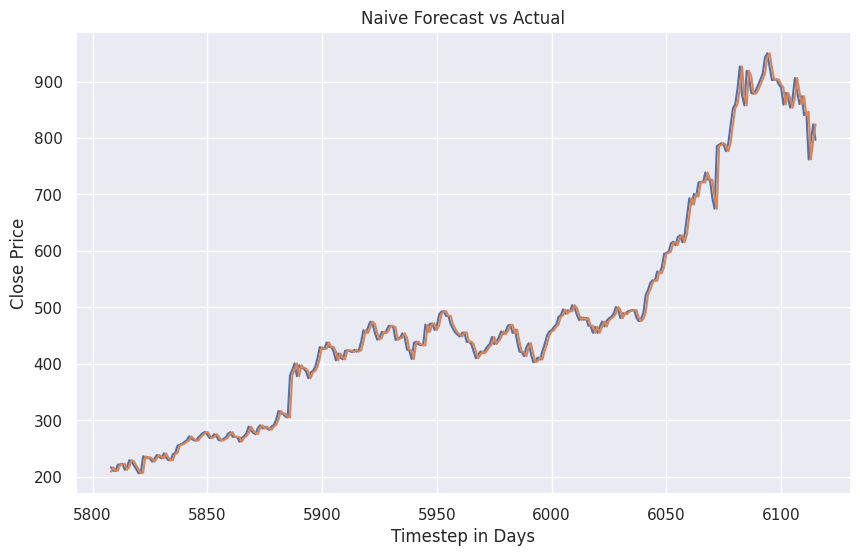

In [ ]:
naive_forecast = series[test_split_index-1 :-1]
plt.figure(figsize=(10, 6))
plt.plot(x_test.index, x_test, label="Actual")
plt.plot(x_test.index, naive_forecast, label="Forecast")
plt.ylabel('Close Price')
plt.xlabel('Timestep in Days')
plt.title('Naive Forecast vs Actual')

Estimating the MAE error for the naive predictor

In [ ]:
naive_forecast_mae = keras.metrics.mean_absolute_error(x_test, naive_forecast).numpy()
model_mae_scores['naive'] = naive_forecast_mae

# view the dictionary of mae scores
model_mae_scores


{'naive': 10.139546282467535}

Using Moving average model to predict close prices for different window value slike 5,20,etc

Text(0.5, 1.0, 'MA(5)')

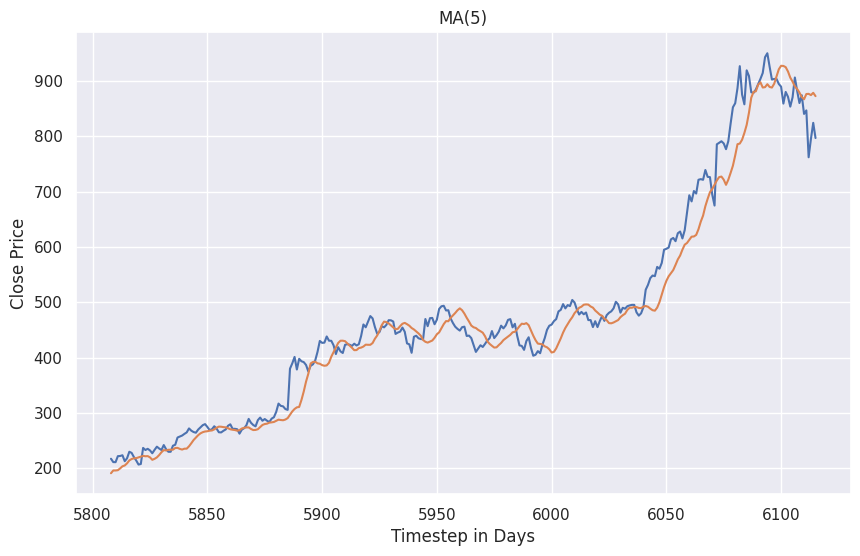

In [ ]:
window = 5

# Create a moving average over the entire dataset
moving_avg = df['Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:df.index.max() - window + 1]

plt.figure(figsize=(10, 6))
plt.plot(x_test.index, x_test)
plt.plot(x_test.index, moving_avg_forecast, label="MA(5)")
plt.ylabel('Close Price')
plt.xlabel('Timestep in Days')
plt.title('MA(5)')

In [ ]:
ma_5= keras.metrics.mean_absolute_error(x_test, moving_avg_forecast).numpy()

model_mae_scores['MA(5)'] = ma_5
model_mae_scores

{'naive': 10.139546282467535, 'MA(5)': 27.83238266233766}

Checking if stationary for applying ARIMA models

In [ ]:
# Testing for stationarity
from statsmodels.tsa.stattools import adfuller

test_result=adfuller(closing_price)

In [ ]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [ ]:
adfuller_test(closing_price)

ADF Test Statistic : 1.0211587445803256
p-value : 0.9944842562837417
#Lags Used : 33
Number of Observations Used : 6082
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Differencing to make the Closing Price Stationary

In [ ]:
df["Difference_1"]=closing_price-closing_price.shift(1)

In [ ]:
adfuller_test(df["Difference_1"].dropna())

ADF Test Statistic : -9.44154009401704
p-value : 4.879739269676404e-16
#Lags Used : 34
Number of Observations Used : 6080
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Hence the First difference can be treated as stationary

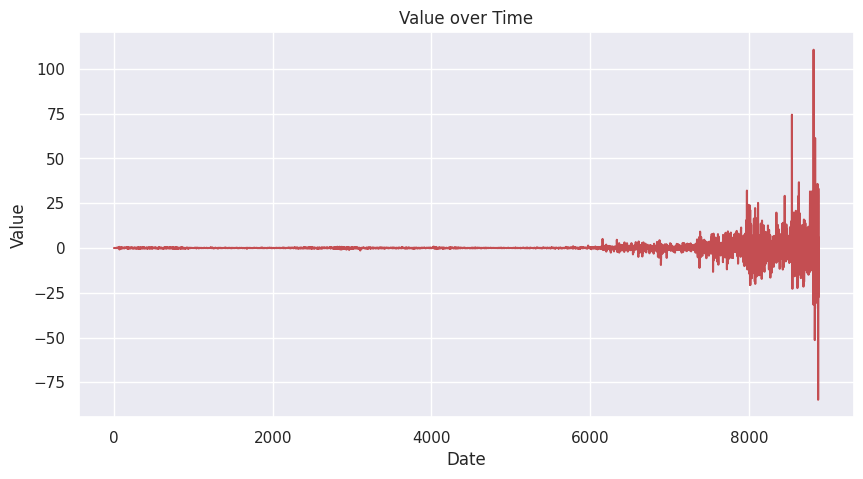

In [ ]:
#Plotting the first difference of Closing Price
plt.figure(figsize=(10,5))
plt.plot(dates,df["Difference_1"],color="r")
plt.title('Value over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


Defining AR model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
nvidia_arima = ARIMA(x_train, order=(1,1,1))
nvidia_arima_fit = nvidia_arima.fit()
print(nvidia_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5284
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6600.575
Date:                Mon, 20 May 2024   AIC                          13207.151
Time:                        12:47:36   BIC                          13226.867
Sample:                             0   HQIC                         13214.042
                               - 5284                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3090      0.025    -12.389      0.000      -0.358      -0.260
ma.L1          0.1873      0.025      7.361      0.000       0.137       0.237
sigma2         0.7124      0.003    247.076      0.0

NormaltestResult(statistic=2557.1406914317986, pvalue=0.0)
This distribution is not a normal distribution


<ipython-input-21-341f05d39f04>:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats


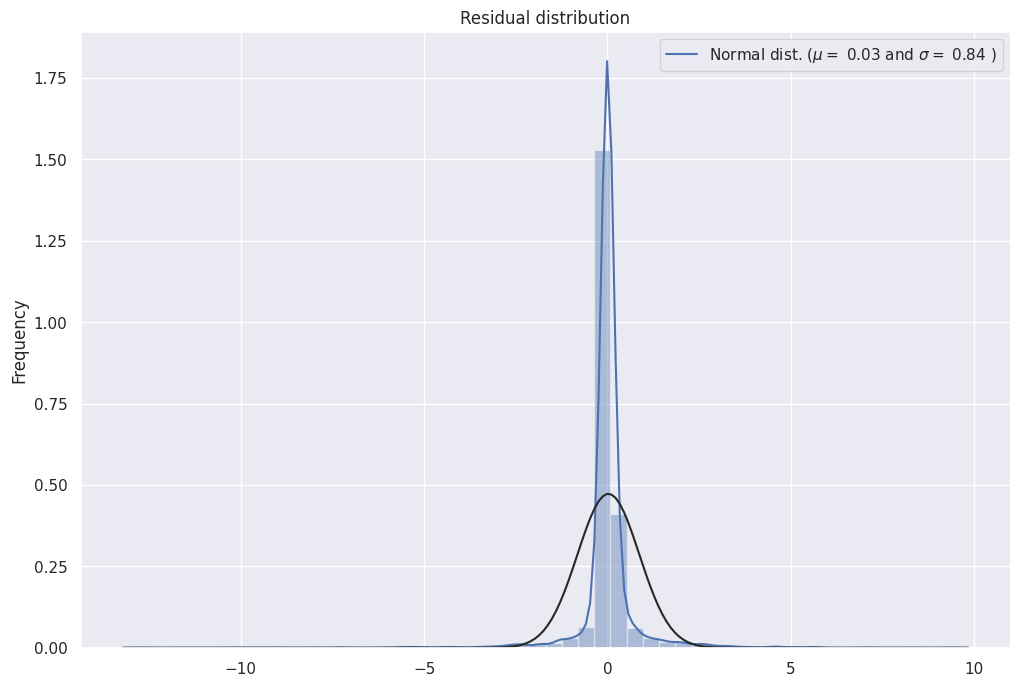

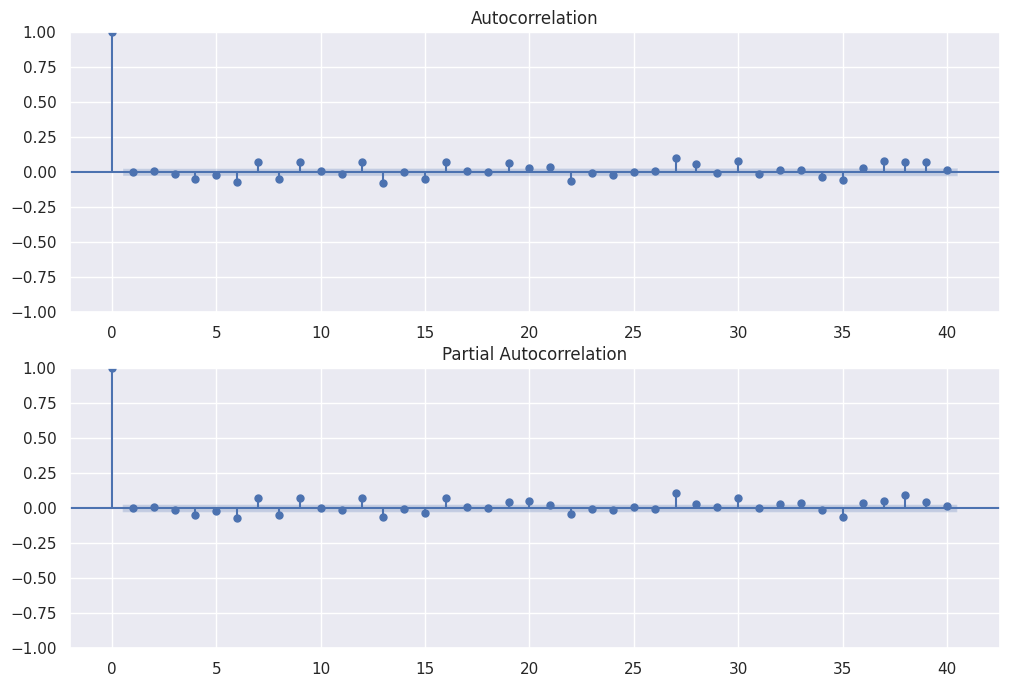

In [ ]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = nvidia_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

In [ ]:
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

# loop through every data point
for time_point in list(x_test.index[-100:]):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = keras.metrics.mean_absolute_error(x_test[-100:], model_predictions).numpy()
# Save to our dictionary of model mae scores
model_mae_scores['ARIMA'] = arima_mae
model_mae_scores

{'naive': 10.139546282467535,
 'MA(5)': 27.83238266233766,
 'ARIMA': 19.69558615040678}

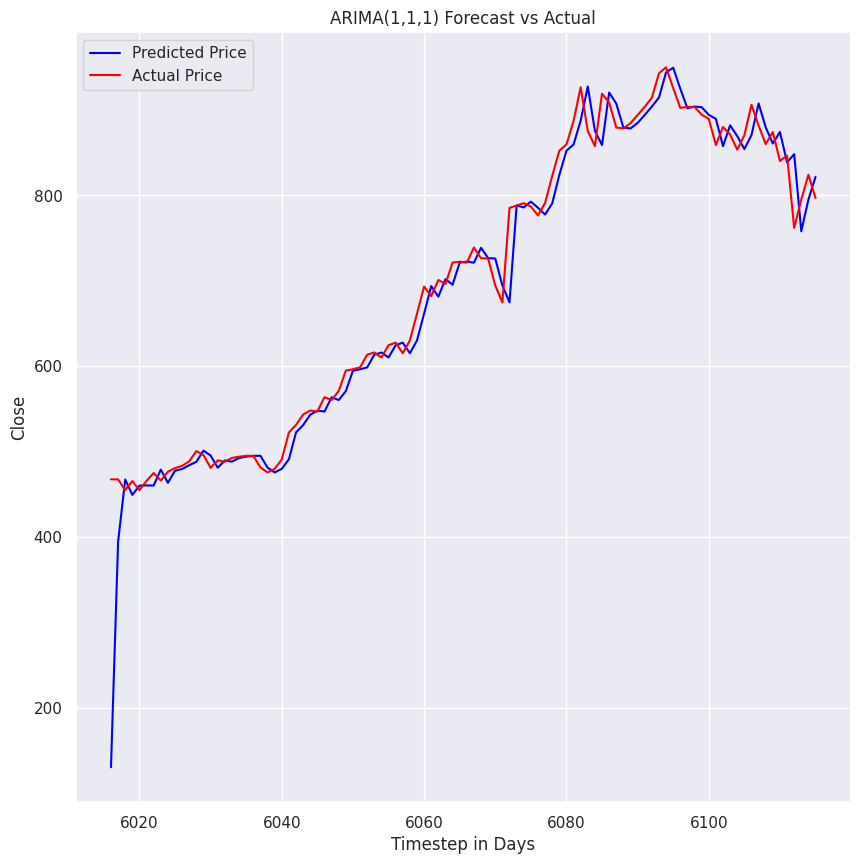

<Figure size 1000x600 with 0 Axes>

In [ ]:

plt.plot(x_test.index[-100:], model_predictions, color='blue',label='Predicted Price')
plt.plot(x_test.index[-100:], x_test[-100:], color='red', label='Actual Price')
plt.ylabel('Close')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(1,1,1) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

We can observe that we are able to get a fair capture of the trend using ARIMA(1,1,1) but Naive estimator outperforms the ARIMA in our case

In [ ]:
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_train)

# loop through every data point
for time_point in list(x_train.index[-250:]):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_train[time_point]
    history.append(true_test_value)


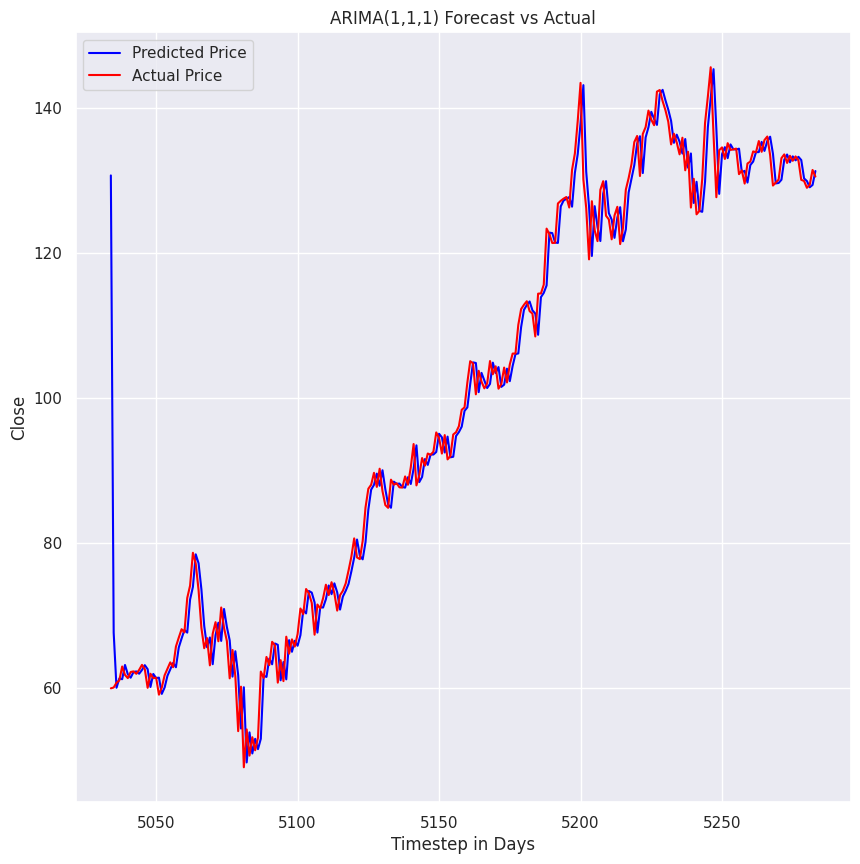

<Figure size 1000x600 with 0 Axes>

In [ ]:

plt.plot(x_train.index[-250:], model_predictions, color='blue',label='Predicted Price')
plt.plot(x_train.index[-250:], x_train[-250:], color='red', label='Actual Price')
plt.ylabel('Close')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(1,1,1) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

**LSTM**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df["Close"]).reshape(-1,1))

In [ ]:
print(df1)

[[3.80335764e-04]
 [3.52907030e-04]
 [3.19991707e-04]
 ...
 [8.36908498e-01]
 [8.67506568e-01]
 [8.38583258e-01]]


In [ ]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
training_size,test_size

(3975, 2141)

In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(3874, 100)
(3874,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(2040, 100)
(2040,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
61/61 [==============================] - 58s 457ms/step - loss: 1.2985e-05 - val_loss: 0.0525
Epoch 2/100
61/61 [==============================] - 26s 435ms/step - loss: 2.5047e-06 - val_loss: 0.0389
Epoch 3/100
61/61 [==============================] - 17s 272ms/step - loss: 1.2342e-06 - val_loss: 0.0079
Epoch 4/100
61/61 [==============================] - 18s 299ms/step - loss: 3.4137e-07 - val_loss: 0.0066
Epoch 5/100
61/61 [==============================] - 14s 236ms/step - loss: 2.8710e-07 - val_loss: 0.0063
Epoch 6/100
61/61 [==============================] - 16s 261ms/step - loss: 2.6168e-07 - val_loss: 0.0061
Epoch 7/100
61/61 [==============================] - 19s 318ms/step - loss: 3.1107e-07 - val_loss: 0.0060
Epoch 8/100
61/61 [==============================] - 21s 335ms/step - loss: 2.7412e-07 - val_loss: 0.0056
Epoch 9/100
61/61 [==============================] - 15s 239ms/step - loss: 2.7230e-07 - val_loss: 0.0057
Epoch 10/100
61/61 [==========================

In [ ]:
import tensorflow as tf

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

64/64 [==============================] - 3s 43ms/step


In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

4.0123616585094215

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

182.6849313899396

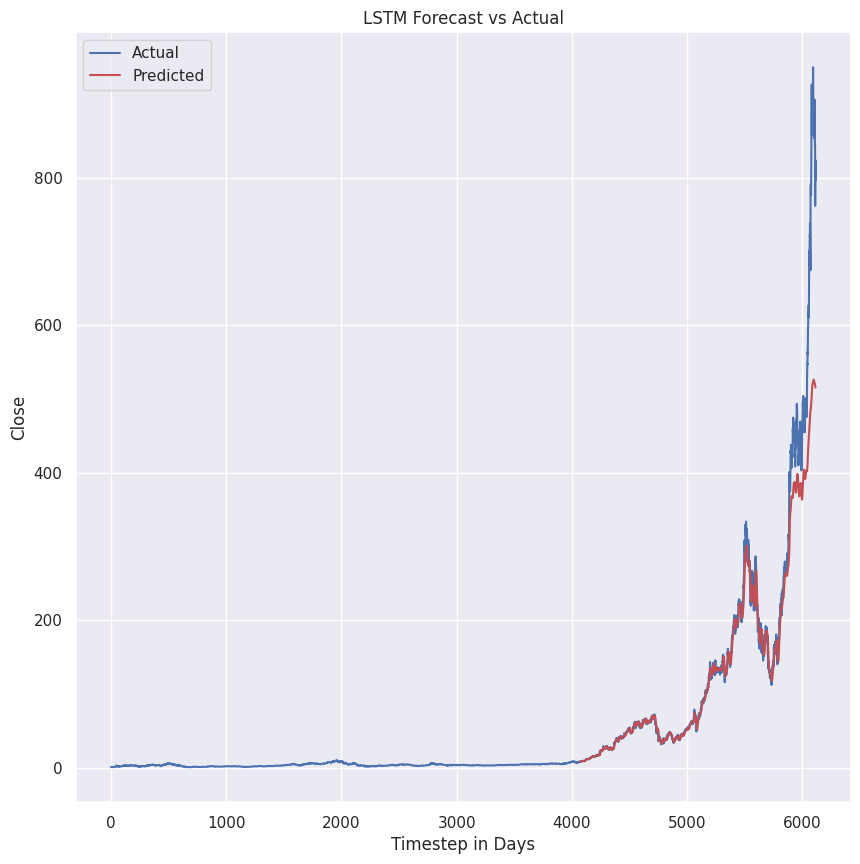

In [ ]:
look_back=100
# trainPredictPlot = numpy.empty_like(df1)
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
# plt.plot(scaler.inverse_transform(df1))
# plt.plot(trainPredictPlot)
plt.plot(scaler.inverse_transform(df1),color="b",label="Actual")
plt.plot(testPredictPlot,color="r",label="Predicted")
plt.ylabel('Close')
plt.xlabel('Timestep in Days')
plt.title('LSTM Forecast vs Actual')
plt.legend()
plt.show()